In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if cuda_output and exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [2]:
!pip install Pillow==4.0.0
!pip install PIL
!pip install image

  Using cached https://files.pythonhosted.org/packages/37/e8/b3fbf87b0188d22246678f8cd61e23e31caa1769ebc06f1664e2e5fe8a17/Pillow-4.0.0-cp36-cp36m-manylinux1_x86_64.whl
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.3.0
    Uninstalling Pillow-5.3.0:
      Successfully uninstalled Pillow-5.3.0
  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL


In [0]:
from PIL import Image

In [4]:
% matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
import torch

from torch.utils.data import Dataset
# default_loader - стандартная функция для загрузки изображений, использует accimage или PIL
from torchvision.datasets import MNIST
# !rm -r '/tmp/mnist/' 2>/dev/null
%time mnist = MNIST('/tmp/mnist/', train=True, download=True)

CPU times: user 613 µs, sys: 29.1 ms, total: 29.8 ms
Wall time: 29.8 ms


tensor(5)


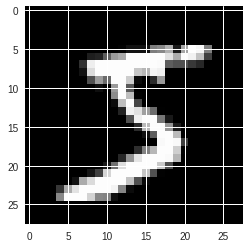

In [5]:
image, target = mnist[0]
print(target)
plt.imshow(np.array(image), 'gray')
plt.show()

## <font color='#cc6666'>Внимание, задача!</font>

Релизуйте ниже датасет **`UrlList`**, конструктор которого на вход принимает список ссылок на изображения.

In [0]:
from torch.utils.data import Dataset
# default_loader - стандартная функция для загрузки изображений, использует accimage или PIL
from torchvision.datasets.folder import default_loader
from PIL import Image
import requests
from io import BytesIO
from torchvision import transforms

class UrlList(Dataset):
    def __init__(self, image_urls, transform=None, loader=default_loader):
        self.imgs = []
        self.classes = []
        self.class_to_idx = []
        
        counter = 0
        print(image_urls)
        for entry in image_urls:
            k,v = entry[0], entry[1]
            try:
                self.imgs.append(Image.open(BytesIO(requests.get(k).content)))
                if not v in self.classes:
                    self.classes.append(v)
                self.class_to_idx.append(self.classes.index(v))
                counter += 1
            except Exception as error:
                print(k, error)
                
        print('Added {} new images'.format(counter))

        self.transform = transform
        self.loader = loader

    def __getitem__(self, index):
        image = self.imgs[index]
        image_class = self.classes[self.class_to_idx[index]]
        
       
        if self.transform is not None:
            image = self.transform(image)

        return image, image_class

    def __len__(self):
        return len(self.imgs)

Покажите его работу на примере:

[('http://bradleymitchell.me/wp-content/uploads/2014/06/decompressed.jpg', '5')]
Added 1 new images
(<PIL.JpegImagePlugin.JpegImageFile image mode=L size=256x256 at 0x7F6FAC550518>, '5')


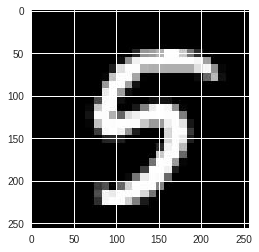

In [7]:
urlDataset = UrlList(
    [
        ('http://bradleymitchell.me/wp-content/uploads/2014/06/decompressed.jpg', "5"),
    ]
)

print(urlDataset[0])
plt.imshow(np.array(urlDataset[0][0]), 'gray')
plt.show()

## <font color='#cc6666'>Внимание, задача!</font>

Реализуйте класс-трансформер, осуществляющий с подаваемым на вход изображением случайное преобразование из группы диэдра $D_4$.

In [0]:
import random
class RandomD4(object):
    def __call__(self, img):
        
        transform = transforms.Compose([
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(random.choice(np.arange(0, 360, 60))),
            transforms.ToTensor()
        ])
        
        return transform(img)[0]

Покажите его работу на примере из MNIST:

2


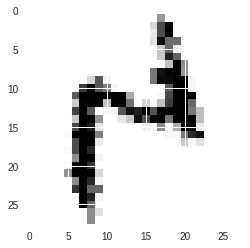

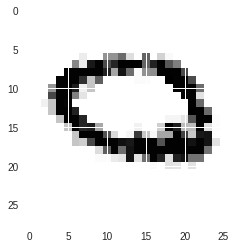

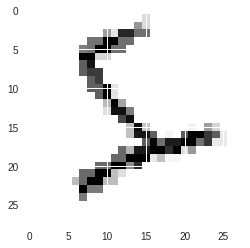

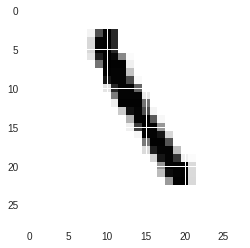

In [9]:
pil_image = mnist[3]
print(len(pil_image))
trans = RandomD4()
for i in range(4):
    pil_image = mnist[i][0]
    plt.imshow(trans(pil_image))
    plt.show()

# Pytorch в бою

## Создание модели сегментации на примере U-Net

![img](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [0]:
import torch
from torch import nn

Часто используемые свертки:

In [0]:
def conv3x3(in_channels, out_channels, dilation=1):
    return nn.Conv2d(in_channels, out_channels, 3, padding=dilation, dilation=dilation)

Один **блок кодировщика** состоит из двух последовательных сверток, активаций и опционального батчнорма:

In [0]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm=False):
        super().__init__()

        self.batch_norm = batch_norm

        self.conv1 = conv3x3(in_channels, out_channels)
        if self.batch_norm:
            self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()
        self.conv2 = conv3x3(out_channels, out_channels)
        if self.batch_norm:
            self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        if self.batch_norm:
            x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        if self.batch_norm:
            x = self.bn2(x)
        x = self.relu2(x)
        return x

Альтернативное объявление:

In [0]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm=False):
        super().__init__()

        self.block = nn.Sequential()
        self.block.add_module('conv1', conv3x3(in_channels, out_channels))
        if batch_norm:
            self.block.add_module('bn1', nn.BatchNorm2d(out_channels))
        self.block.add_module('relu1', nn.ReLU())
        self.block.add_module('conv2', conv3x3(out_channels, out_channels))
        if batch_norm:
            self.block.add_module('bn2', nn.BatchNorm2d(out_channels))
        self.block.add_module('relu2', nn.ReLU())

    def forward(self, x):
        return self.block(x)

In [0]:
def encoder_block(in_channels, out_channels, batch_norm=False):
    block = nn.Sequential()
    block.add_module('conv1', conv3x3(in_channels, out_channels))
    if batch_norm:
        block.add_module('bn1', nn.BatchNorm2d(out_channels))
    block.add_module('relu1', nn.ReLU())
    block.add_module('conv2', conv3x3(out_channels, out_channels))
    if batch_norm:
        block.add_module('bn2', nn.BatchNorm2d(out_channels))
    block.add_module('relu2', nn.ReLU())
    return block

In [0]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_filters, num_blocks):
        super().__init__()

        self.num_blocks = num_blocks
        for i in range(num_blocks):
            in_channels = in_channels if not i else num_filters * 2 ** (i - 1)
            out_channels = num_filters * 2**i
            self.add_module(f'block{i + 1}', encoder_block(in_channels, out_channels))
            if i != num_blocks - 1:
                self.add_module(f'pool{i + 1}', nn.MaxPool2d(2, 2))

    def forward(self, x):
        acts = []
        for i in range(self.num_blocks):
            x = self.__getattr__(f'block{i + 1}')(x)
            acts.append(x)
            if i != self.num_blocks - 1:
                x = self.__getattr__(f'pool{i + 1}')(x)
                
        return acts

In [0]:
class DecoderBlock(nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.up_pooling = nn.Upsample(scale_factor=2, mode='bilinear')
        
        self.up_convolution = conv3x3(out_channels * 2, out_channels)
        
        self.convolution_1 = conv3x3(out_channels * 2, out_channels)
        self.convolution_2 = conv3x3(out_channels, out_channels)

    def forward(self, down, left):
        output = self.up_pooling(down)
        output = self.up_convolution(output)
        
        output = torch.cat([left, output], 1)
        
        output = self.convolution_1(output)
        output = self.convolution_2(output)
        
        return output

In [0]:
class Decoder(nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        for i in range(num_blocks):
            self.add_module(f'block{num_blocks - i}', DecoderBlock(num_filters * 2**i))

    def forward(self, acts):
        up = acts[-1]
        for i, left in enumerate(acts[-2::-1]):
            up = self.__getattr__(f'block{i + 1}')(up, left)
        return up

## Использование готового кодировщика

In [0]:
from torchvision.models import resnet18, densenet121

In [0]:
class Densnet121Encoder(torch.nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        
        backbone = densenet121(pretrained).features
        
        self.add_module('initial_block', nn.Sequential(*[x for x in backbone.modules()][1:5]))
        
        self.add_module('encoder_block_1', nn.Sequential(*[backbone.denseblock1, backbone.transition1]))
        self.add_module('encoder_block_2',  nn.Sequential(*[backbone.denseblock2, backbone.transition2]))
        self.add_module('encoder_block_3',  nn.Sequential(*[backbone.denseblock3, backbone.transition3]))
        self.add_module('encoder_block_4',  nn.Sequential(*[backbone.denseblock4, backbone.norm5]))
        
    def forward(self, x):
        step_results = []
        x = self.__getattr__('initial_block')(x)
        step_results.append(torch.zeros_like(x))
        
        for i in range(4):
            x = self.__getattr__(f'encoder_block_{i + 1}')(x)
            step_results.append(x)
        
        return step_results

In [0]:
class ResNet18Encoder(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        
        backbone = resnet18(pretrained=pretrained)
        
        self.add_module('initial_block', nn.Sequential(*[x for x in backbone.modules()][1:5]))
        
        self.add_module('encoder_block_1', backbone.layer1)
        self.add_module('encoder_block_2', backbone.layer2)
        self.add_module('encoder_block_3', backbone.layer3)
        self.add_module('encoder_block_4', backbone.layer4)


    def forward(self, x):
        step_results = []
        x = self.__getattr__('initial_block')(x)
        
        for i in range(4):
            x = self.__getattr__(f'encoder_block_{i + 1}')(x)
            step_results.append(x)
            
        return step_results

In [0]:
class FinalLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.full_convolution_1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        
        self.full_convolution_2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=2, stride=2),
            nn.BatchNorm2d(1),
            nn.ReLU(inplace=True)
        )
       
    def forward(self, input):
        output = self.full_convolution_1(input)
        output = self.conv(output)
        output = self.full_convolution_2(output)
        
        return output

In [0]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2, output_padding=1):
        super().__init__()
        
        self.convolution_1 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels//4, 1),
            nn.BatchNorm2d(in_channels//4),
            nn.ReLU(inplace=True)
        )   
        
        self.convolution_full = nn.Sequential(
            nn.ConvTranspose2d(in_channels//4, in_channels//4, 3, stride=stride, padding=1, output_padding=output_padding),
            nn.BatchNorm2d(in_channels//4),
            nn.ReLU(inplace=True)
        ) 
        
        self.convolution_2 = nn.Sequential(
            nn.Conv2d(in_channels//4, out_channels, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ) 
        
    def forward(self, down, left):
        output = self.convolution_1(down)
        output = self.convolution_full(output)
        output = self.convolution_2(output)
        return left + output

In [0]:
class CustomDecoder(nn.Module):
    def __init__(self, encoder_type="resnet"):
        super().__init__()
        self.encoder_type = encoder_type

            
        if self.encoder_type == 'resnet':
            self.add_module('decoder_block_4', DecoderBlock(512, 256))
            self.add_module('decoder_block_3', DecoderBlock(256, 128))
            self.add_module('decoder_block_2', DecoderBlock(128, 64))
            self.add_module('decoder_block_1', DecoderBlock(64, 64, output_padding=0))
         
        elif self.encoder_type == "densenet":
            self.add_module('decoder_block_4', DecoderBlock(1024, 512, stride=1, output_padding=0))
            self.add_module('decoder_block_3', DecoderBlock(512, 256))
            self.add_module('decoder_block_2', DecoderBlock(256, 128))
            self.add_module('decoder_block_1', DecoderBlock(128, 64))
            
        else:
            raise Exception("Unsupported encoder type: {}".format(encoder_type))

    def forward(self, input):
        output = input[-1]
        
        for i, left in enumerate(input[-2::-1]):
            output = self.__getattr__(f'decoder_block_{4-i}')(output, left)
            
        return output

In [0]:
class LinkNet(nn.Module):
    def __init__(self, encoder_type="resnet"):
        super().__init__()
        self.encoder_type = encoder_type
        
        if self.encoder_type == "resnet":
            self.encoder = ResNet18Encoder(pretrained=True)
        elif self.encoder_type == "densenet":
            self.encoder = Densnet121Encoder(pretrained=True)
        else:
            raise Exception("Unsupported encoder type: {}".format(encoder_type))
            
        self.decoder = CustomDecoder(self.encoder_type)
        self.final = FinalLayer()

    def forward(self, input):
        encoder_outputs = self.encoder(input)
        output = self.decoder(encoder_outputs)
        return self.final(output)
    

In [25]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = LinkNet(encoder_type="resnet")
print(count_parameters(model))


model = LinkNet(encoder_type="densenet")
print(count_parameters(model))


11534371


/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


8293187


## <font color='#cc6666'>Внимание, задача!</font>


**Реализуйте датасет** для игрушечной задачи сегментации, реализующий такие данные:

![img](https://raw.githubusercontent.com/jakeret/tf_unet/master/docs/toy_problem.png)

Т.е. необходимо генерировать цветные эллипсы на цветном фоне и к итоговой картинке добавлять шум разной природы.

При этом датасет выдает как изображение, так и его бинарную маску.

In [0]:
from PIL import Image, ImageDraw
import skimage
from skimage import data
from skimage import util as skiutil
from random import randint

class Ellipses(Dataset):
    
    def __init__(self, num_samples=128, noise=False, class_amount=3, width=256, height=256, transform=None, loader=default_loader, random_seed=None):
        self.noise = noise
        self.random_seed=random_seed if random_seed else 1
        self.classes = [ x for x in range(class_amount)]
        self.transform = transform
        self.loader = loader
        self.num_samples = num_samples
        self.width = width
        self.height = height
        
    @staticmethod    
    def get_random_color():
        return (randint(0, 255), randint(0, 255), randint(0, 255))
        
    def generate_circles(self, count_of_each=3):
        pil_image = Image.new("RGB", (self.width, self.height), color=self.background)
        pil_image_mask = Image.new("1", (self.width, self.height), color=0)
        
        draw = ImageDraw.Draw(pil_image)
        draw_mask = ImageDraw.Draw(pil_image_mask)
        
        for class_ix in self.classes:
            color = self.get_random_color()
            while color == self.background:
                color = self.get_random_color()   
                
            for i in range(count_of_each):
                x, y = int(random.random() * self.width), int(random.random() * self.height)
                radius = int(min(min(abs(self.width - x), x), min(abs(self.height - y), y)) * random.random())

                x1, y1 = x - radius, y - radius
                x2, y2 = x + radius, y + radius

                draw.ellipse((x1, y1, x2, y2), fill = color)
                draw_mask.ellipse((x1, y1, x2, y2), fill = 1)
                
        return pil_image, pil_image_mask

    def add_noise(self, image, s_vs_p = 0.5,amount = 0.25):
        image = np.array(image)
        row,col,ch = image.shape

        out = np.copy(image)
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))  for i in image.shape]
        out[coords] = 1
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
        out[coords] = 0
        return Image.fromarray(out)

    def __getitem__(self, index):
        if index > self.num_samples - 1:
            raise IndexError
        #random.seed(100000*random.random())
        seed = self.random_seed*100000 + (1 + index)
        random.seed(seed)
        np.random.seed(seed)
        
        self.background = self.get_random_color()
        self.image, self.image_mask = self.generate_circles()
        
        if self.noise:
            self.image = self.add_noise(self.image)
            
        if self.transform is not None:
            self.image = self.transform(self.image)
            self.image_mask = self.transform(self.image_mask)
            
        return self.image, self.image_mask

    def __len__(self):
        return self.num_samples

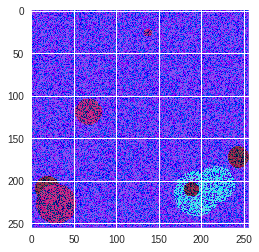

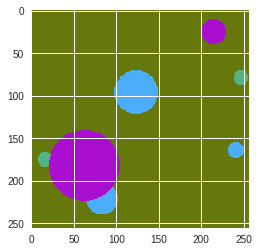

In [60]:
ellipses = Ellipses(num_samples=1, noise=True)

for image in ellipses:
    plt.imshow(image[0])
    plt.show()
ellipses = Ellipses(num_samples=1, random_seed=42, noise=False)
for image in ellipses:
    plt.imshow(image[0])
    plt.show()

Для решения этой задачи **реализуйте сеть LinkNet** на основе кодировщика двух предобученных сетей `torchvision` из разных семейств (не VGG).

В качестве лосса рекомендуется использовать `BCEWithLogitsLoss`.

---



In [28]:
raise Exception()

Exception: ignored

In [0]:
from torch.optim import lr_scheduler

def train_epoch(model, optimizer, loader, model_loss_function):
    model.train()
    loss_epoch_results = []
    last_images = None
    
    ix = 0
    for images, labels in loader:
        ix = ix + 1
        images = images.cuda()
        labels = labels.cuda()
        
        optimizer.zero_grad()
        predicted_images = model(images)
        loss = model_loss_function(predicted_images, labels)
        loss_value = loss.item()
        loss_epoch_results.append(loss_value)
        #print("[Step {}] Train loss: {}".format(ix, loss_value))
        
        loss.backward()
        optimizer.step()
        
        if ix == len(loader):
          color_real_imgs = images.data.cpu().numpy()
          color_img = color_real_imgs[0].reshape(3, 256,256)
          color_img = np.swapaxes(color_img,1,2)
          color_img = np.swapaxes(color_img,0,2)
          predicted_imgs = predicted_images.data.cpu().numpy()
          real_imgs = labels.data.cpu().numpy()
          last_images = [color_img, predicted_imgs[0].reshape(256,256), real_imgs[0].reshape(256,256)]
          
        #print(torch.cuda.memory_allocated())
        del images, labels, predicted_images
        torch.cuda.empty_cache()
        #print(torch.cuda.memory_allocated())
        
    return loss_epoch_results, last_images
        
def evaluate_loss(model, model_loss_function, loader):
    model.eval()
    loss_epoch_results = []
    last_images = None
    
    ix = 0
    for images, labels in loader:
      ix = ix + 1
      with torch.no_grad():
        images = images.cuda()
        labels = labels.cuda()
        predicted_images = model(images)
        loss = model_loss_function(predicted_images, labels)
        
        loss_value = loss.item()
        loss_epoch_results.append(loss_value)
        #print("[Step {}] Test loss: {}".format(ix, loss_value))
        
        if (ix) == len(loader):
          color_real_imgs = images.data.cpu().numpy()
          color_img = color_real_imgs[0].reshape(3, 256,256)
          color_img = np.swapaxes(color_img,1,2)
          color_img = np.swapaxes(color_img,0,2)
          predicted_imgs = predicted_images.data.cpu().numpy()
          real_imgs = labels.data.cpu().numpy()
          last_images = [color_img, predicted_imgs[0].reshape(256,256), real_imgs[0].reshape(256,256)]

        #print(torch.cuda.memory_allocated())
        del images, labels, predicted_images
        torch.cuda.empty_cache()
        #print(torch.cuda.memory_allocated())
        
    return loss_epoch_results, last_images
    
    
def train(model, optimizer, scheduler, data_loader_train, data_loader_test, writer, n_epochs, loss_function):
    train_loss, test_loss = [], []
    
    for epoch in range(n_epochs):
        print("Epoch {} started!".format(epoch+1))
        scheduler.step()
        new_train_loss, train_last_images = train_epoch(model, optimizer, data_loader_train, loss_function)
        train_loss = train_loss + new_train_loss
        
        if train_last_images:
          print("Train images:")
          fig=plt.figure(figsize=(8, 14))
          fig.add_subplot(1,3,1)
          plt.imshow(train_last_images[0])
          fig.add_subplot(1,3,2)
          plt.imshow(train_last_images[1])
          fig.add_subplot(1,3,3)
          plt.imshow(train_last_images[2])
          plt.show()
          
        new_test_loss, test_last_images = evaluate_loss(model, loss_function, data_loader_test)
        test_loss.append(np.mean(new_test_loss))
        
        if test_last_images:
          print("Test images:")
          fig=plt.figure(figsize=(8, 14))
          fig.add_subplot(1,3,1)
          plt.imshow(test_last_images[0])
          fig.add_subplot(1,3,2)
          plt.imshow(test_last_images[1])
          fig.add_subplot(1,3,3)
          plt.imshow(test_last_images[2])
          plt.show()
          

        print("[Epoch {}] Train avg loss: {}".format(epoch+1, np.mean(new_train_loss)))
        print("[Epoch {}] Test avg loss: {}".format(epoch+1, np.mean(new_test_loss)))
        

        
#     for ix in range(len(train_loss)):
#       summary = tf.Summary(value=[
#           tf.Summary.Value(tag="{}_train_loss_{}".format(str(type(model)), ix), simple_value=train_loss[ix]),
#           tf.Summary.Value(tag="{}_test_loss_{}".format(str(type(model)), ix), simple_value=test_loss[ix]),
#       ])
#       writer.add_summary(summary)
#     writer.close()
    
    fig=plt.figure(figsize=(16, 8))
    train_loss_ax = fig.add_subplot(1, 2, 1)
    train_loss_ax.plot(range(len(train_loss)), train_loss, 'b-')

    test_loss_ax = fig.add_subplot(1, 2, 2)
    test_loss_ax.plot(range(len(test_loss)), test_loss, 'r-')

    train_loss_ax.set_ylabel('Train Loss')
    test_loss_ax.set_ylabel('Test Loss')
    train_loss_ax.set_xlabel('Batch №')
    test_loss_ax.set_xlabel('Epoch №')
    plt.show()


In [89]:
print(torch.cuda.memory_allocated())

381032960


Epoch 1 started!
Train images:


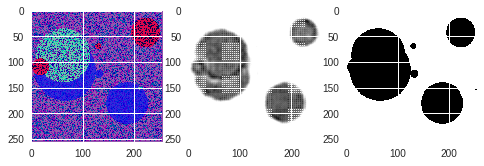

Test images:


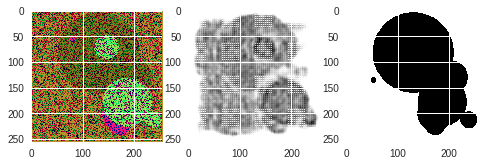

[Epoch 1] Train avg loss: 0.6719523202627897
[Epoch 1] Test avg loss: 0.6875071227550507
Epoch 2 started!
Train images:


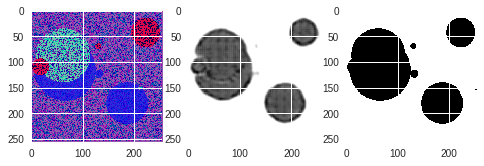

Test images:


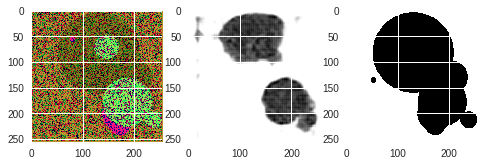

[Epoch 2] Train avg loss: 0.6427136734127998
[Epoch 2] Test avg loss: 0.6492999345064163
Epoch 3 started!
Train images:


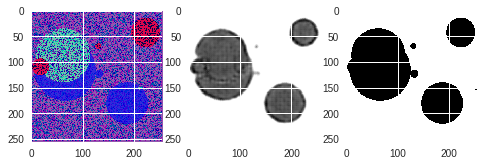

Test images:


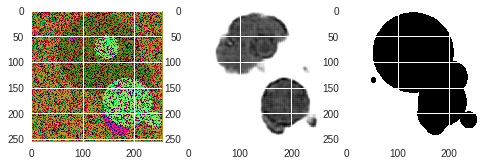

[Epoch 3] Train avg loss: 0.6203302964568138
[Epoch 3] Test avg loss: 0.6156978607177734
Epoch 4 started!
Train images:


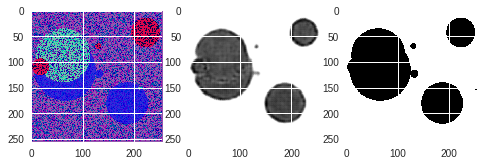

Test images:


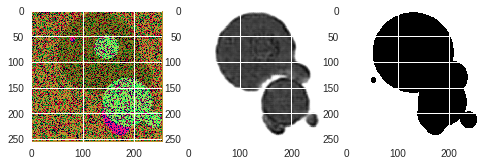

[Epoch 4] Train avg loss: 0.6084062531590462
[Epoch 4] Test avg loss: 0.6052008867263794
Epoch 5 started!
Train images:


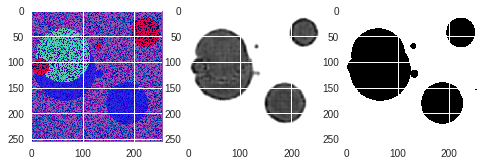

Test images:


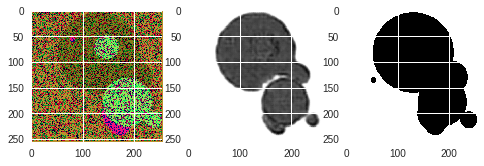

[Epoch 5] Train avg loss: 0.6062208022922277
[Epoch 5] Test avg loss: 0.6041441112756729
Epoch 6 started!
Train images:


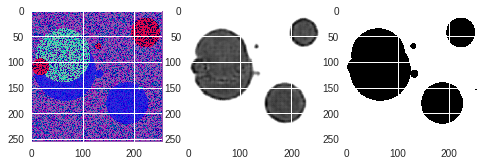

Test images:


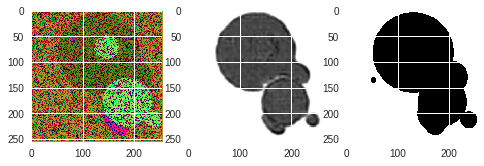

[Epoch 6] Train avg loss: 0.6043294798582792
[Epoch 6] Test avg loss: 0.6018293648958206
Epoch 7 started!
Train images:


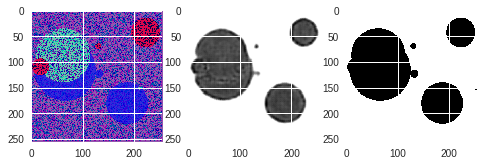

Test images:


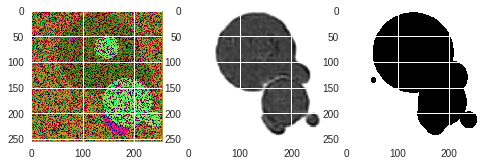

[Epoch 7] Train avg loss: 0.6032964196056128
[Epoch 7] Test avg loss: 0.6002084910869598
Epoch 8 started!
Train images:


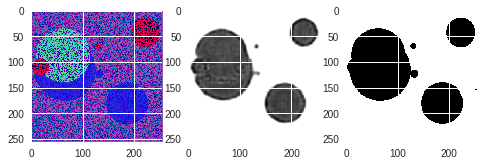

Test images:


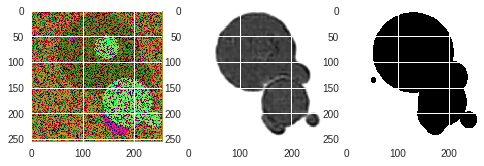

[Epoch 8] Train avg loss: 0.6031095534563065
[Epoch 8] Test avg loss: 0.6001480519771576
Epoch 9 started!
Train images:


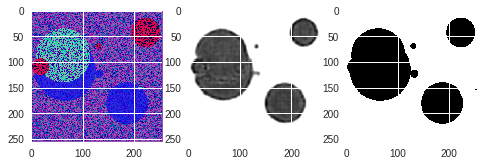

Test images:


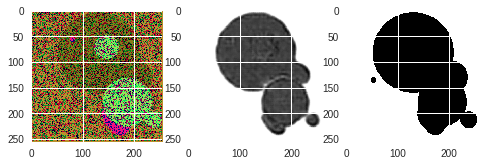

[Epoch 9] Train avg loss: 0.6029316745698452
[Epoch 9] Test avg loss: 0.5999167412519455
Epoch 10 started!
Train images:


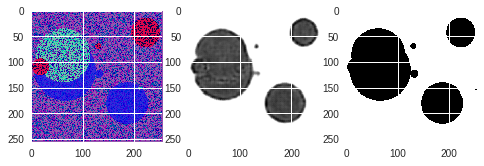

Test images:


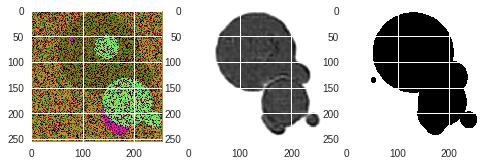

[Epoch 10] Train avg loss: 0.6028256770223379
[Epoch 10] Test avg loss: 0.5998491048812866
Epoch 11 started!
Train images:


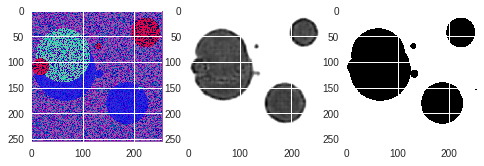

Test images:


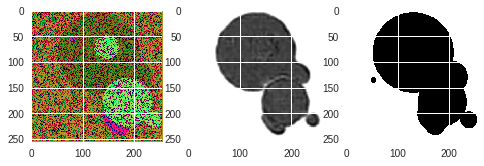

[Epoch 11] Train avg loss: 0.6028077639639378
[Epoch 11] Test avg loss: 0.5998261868953705
Epoch 12 started!
Train images:


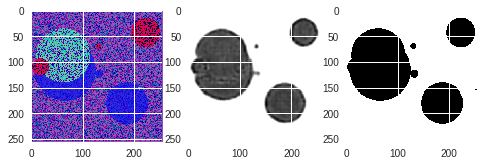

Test images:


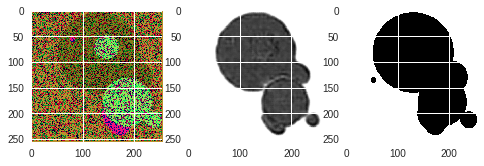

[Epoch 12] Train avg loss: 0.6027899831533432
[Epoch 12] Test avg loss: 0.5998046398162842


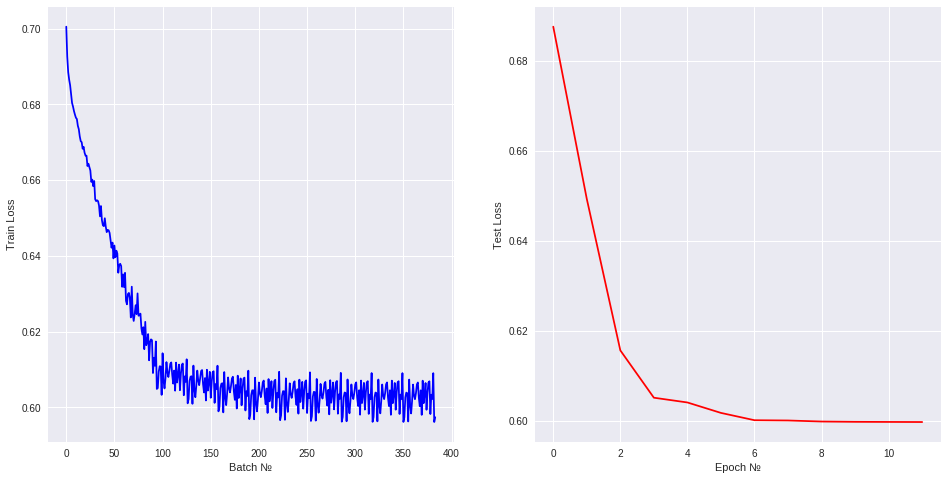

In [94]:
from torch.optim import lr_scheduler
from torch.optim import Adam
import tensorflow as tf
train_data = Ellipses(num_samples=2048, noise=True, transform=transforms.ToTensor())
test_data = Ellipses(num_samples=256, noise=True, transform=transforms.ToTensor(), random_seed=43)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64)

#del model
torch.cuda.empty_cache()

model = LinkNet(encoder_type="resnet").cuda()
#model = LinkNet(encoder_type="densenet").cuda()
torch.cuda.empty_cache()

optimizer = Adam(model.parameters(), lr=0.0025)

scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

writer = tf.summary.FileWriter("log/")

loss_function = nn.BCEWithLogitsLoss()

n_epochs = 12

train(model, optimizer, scheduler, train_loader, test_loader, writer, n_epochs, loss_function)

**Проиллюстрируйте процесс обучения** сети скриншотами из `tensorboard` (см. `lanpa/tensorboard-pytorch`).

Необходимо в частности отобразить кривую обучения и примеры эволюции качества выдаваемых масок.

Решил отказаться от tensorboard, так как в google collab не смог его встроить: вместо этого вывел промежуточные результаты эксперимента в stdout, в том числе и примеры эволюции качества масок

Они находится в конце логов для каждого из экспериментов


/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


Epoch 1 started!
Train images:


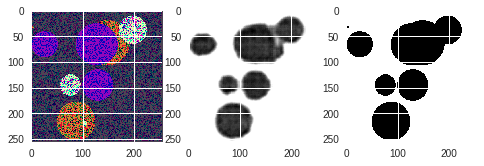

Test images:


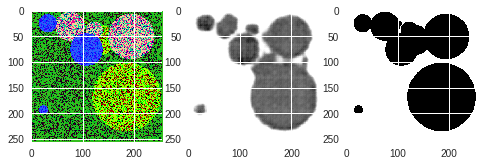

[Epoch 1] Train avg loss: 0.6486655035987496
[Epoch 1] Test avg loss: 0.6374642625451088
Epoch 2 started!
Train images:


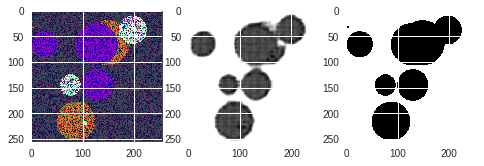

Test images:


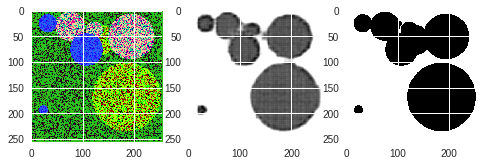

[Epoch 2] Train avg loss: 0.600244683213532
[Epoch 2] Test avg loss: 0.5734613239765167
Epoch 3 started!
Train images:


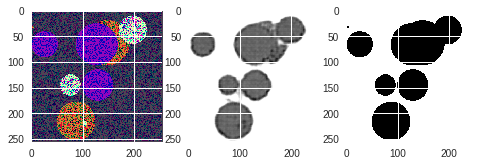

Test images:


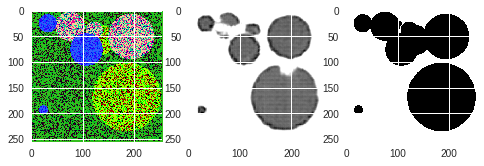

[Epoch 3] Train avg loss: 0.5753910802304745
[Epoch 3] Test avg loss: 0.5783944129943848
Epoch 4 started!
Train images:


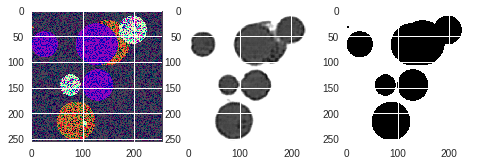

Test images:


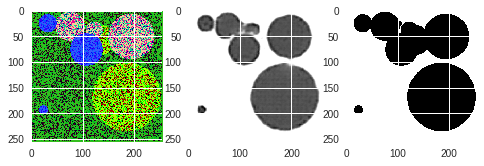

[Epoch 4] Train avg loss: 0.5601412001997232
[Epoch 4] Test avg loss: 0.5599253326654434
Epoch 5 started!
Train images:


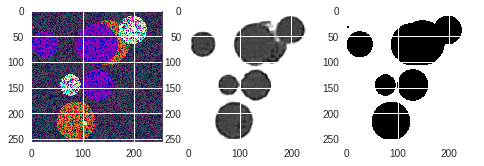

Test images:


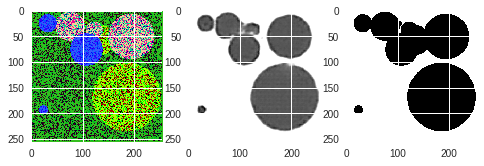

[Epoch 5] Train avg loss: 0.557109440676868
[Epoch 5] Test avg loss: 0.5565504357218742
Epoch 6 started!
Train images:


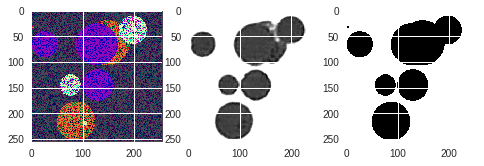

Test images:


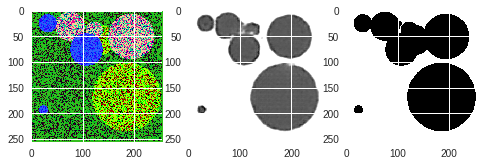

[Epoch 6] Train avg loss: 0.5548014240339398
[Epoch 6] Test avg loss: 0.5544668957591057
Epoch 7 started!
Train images:


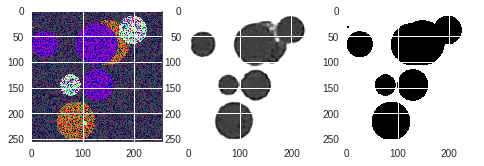

Test images:


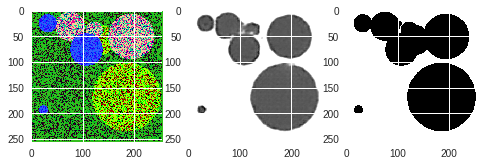

[Epoch 7] Train avg loss: 0.5535184135660529
[Epoch 7] Test avg loss: 0.551083967089653
Epoch 8 started!
Train images:


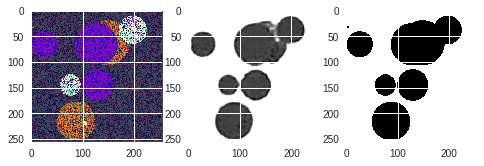

Test images:


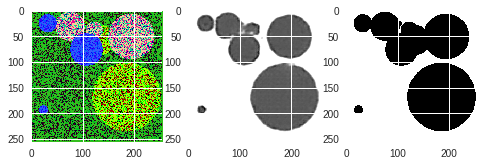

[Epoch 8] Train avg loss: 0.5532935624942183
[Epoch 8] Test avg loss: 0.5507477894425392
Epoch 9 started!
Train images:


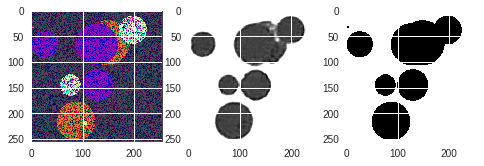

Test images:


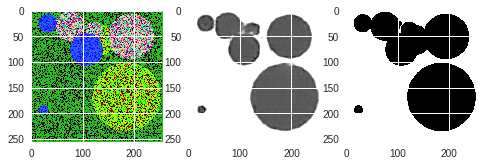

[Epoch 9] Train avg loss: 0.5530731147155166
[Epoch 9] Test avg loss: 0.5504737347364426
Epoch 10 started!
Train images:


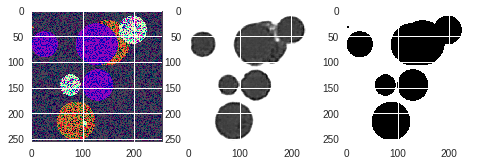

Test images:


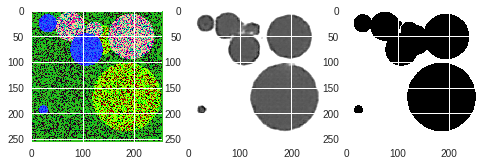

[Epoch 10] Train avg loss: 0.5529411127790809
[Epoch 10] Test avg loss: 0.5500635057687759
Epoch 11 started!
Train images:


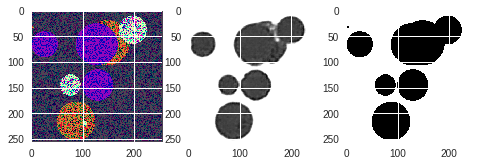

Test images:


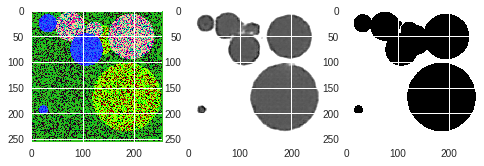

[Epoch 11] Train avg loss: 0.5529189705848694
[Epoch 11] Test avg loss: 0.5500360503792763
Epoch 12 started!
Train images:


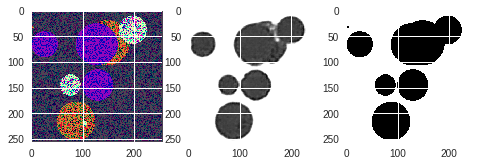

Test images:


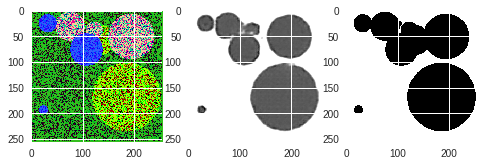

[Epoch 12] Train avg loss: 0.5528967715799809
[Epoch 12] Test avg loss: 0.550009198486805


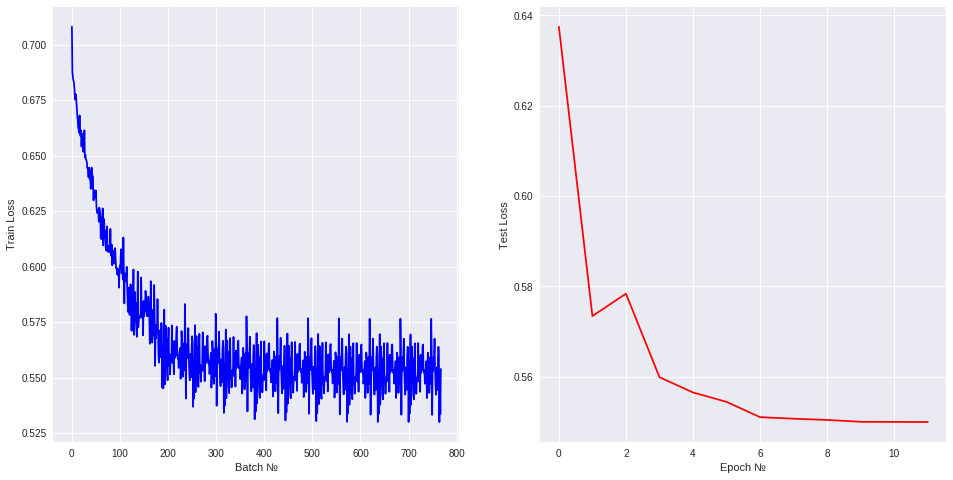

In [95]:
from torch.optim import lr_scheduler
from torch.optim import Adam
import tensorflow as tf
train_data = Ellipses(num_samples=2048, noise=True, transform=transforms.ToTensor())
test_data = Ellipses(num_samples=256, noise=True, transform=transforms.ToTensor(), random_seed=42)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32)

#del model
torch.cuda.empty_cache()

model = LinkNet(encoder_type="densenet").cuda()
torch.cuda.empty_cache()

optimizer = Adam(model.parameters(), lr=0.0025)

scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

writer = tf.summary.FileWriter("log/")

loss_function = nn.BCEWithLogitsLoss()

n_epochs = 12

train(model, optimizer, scheduler, train_loader, test_loader, writer, n_epochs, loss_function)